Continued from Modeling and Evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
train = pd.read_csv("train.csv")
y = train["loss"]
train = train.ix[:, 1:-1]

As we saw previously, **cat1**, **cat2**, ... **cat116** contains categorical features, which were turned into continuous features using one-hot encoding.

This may work in theory, but one-hot encoding is very sparse and it practice it may cause memory issues (e.g. even on a desktop with 16GB RAM)

Remember that some of these **cat** columns contains a large number of unique values. For example, **cat100** contains 15 unique values:

In [3]:
train["cat100"].value_counts()

F    42970
I    39933
L    19961
K    13817
G    12935
J    12027
H    10776
A     9402
N     7592
B     6608
O     5697
M     5185
C      836
D      553
E       26
Name: cat100, dtype: int64

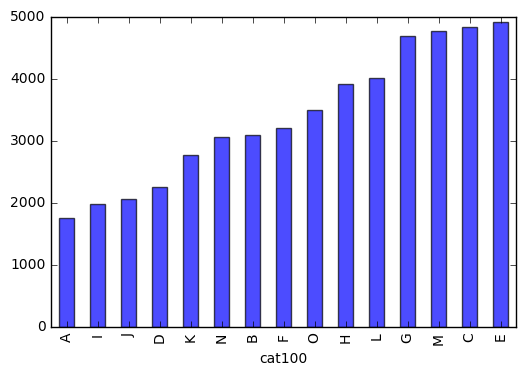

In [4]:
mean = y.groupby(train.ix[:, "cat100"]).mean()
mean = mean.sort_values()
mean.plot(kind="bar", color="b", alpha=0.7)
plt.show()    

As we saw in the Exploratory Data Analysis part, in many cases the categorical label appears to be a good indicator of the target value. As opposed to turning **cat100** into a 15-column matrix in one-hot encoding with 0's and 1's, we could directly turn the categorical value into a real value.

In [5]:
# Compute group mean
mean= y.groupby(train.ix[:, "cat100"]).mean()
mean

cat100
A    1746.242170
B    3090.589334
C    4835.537141
D    2253.682134
E    4914.809615
F    3200.098940
G    4678.556561
H    3906.754900
I    1970.402509
J    2063.532038
K    2772.549697
L    4005.581714
M    4767.290926
N    3055.795964
O    3496.489035
Name: loss, dtype: float64

In [6]:
# Normalize by sum
mean = mean.sort_values()
mean /= mean.sum()
mean
# This is essentially a dict from categorical label to group mean

cat100
A    0.034403
I    0.038820
J    0.040654
D    0.044401
K    0.054623
N    0.060203
B    0.060889
F    0.063046
O    0.068886
H    0.076968
L    0.078915
G    0.092174
M    0.093922
C    0.095267
E    0.096828
Name: loss, dtype: float64

Group mean can be used in place of the categorical labels

In [7]:
pd.concat([train["cat100"],
           train.ix[:, "cat100"].map(lambda x: mean[x])], axis=1, keys=["cat label", "group mean"])[:10]

,cat label,group mean
0,B,0.060889
1,L,0.078915
2,L,0.078915
3,I,0.038820
4,F,0.063046
5,J,0.040654
6,J,0.040654
7,H,0.076968
8,C,0.095267
9,F,0.063046


We iterate this process on all cat variables, and turn the cat labels into group means if the number of unique values is at least 4

In [8]:
train_msged = pd.DataFrame()

threshold = 4
for i in range(116):
    if train.ix[:, i].unique().size <= threshold:
        cat_msged = pd.get_dummies(train["cat" + str(i + 1)], prefix="cat" + str(i + 1))
    else:
        mean= y.groupby(train.ix[:, i]).mean()
        mean = mean.sort_values()
        mean /= mean.sum()
        cat_msged = train.ix[:, i].map(lambda x: mean[x])
    
    train_msged = pd.concat([train_msged, cat_msged], axis=1)

# Combine with the continuous features    
train_msged = pd.concat([train_msged, train.ix[:, "cont1" : "cont14"]], axis=1)    

In [9]:
X, y = train_msged.values, y.values

The number of features is reduced from 1153 down to 246:

In [10]:
X.shape

(188318, 246)

Split X and y into training and test

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

del X, y

Train an ensemble of 50 MultiLayer Perceptron

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
mlpr_ensemble = BaggingRegressor(MLPRegressor(hidden_layer_sizes=(100,)), n_estimators=50, n_jobs=2)

pl = Pipeline(steps=[("scaler", scaler),
                     ("est", mlpr_ensemble)])

Functions to convert target value **y** between linear scale and log scale

In [13]:
def log1p(x, base=10.):
    return np.log(x + 1) / np.log(base)

def expm1(x, base=10.):
    return base**x - 1.

In [14]:
pl.fit(X_train, log1p(y_train))

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('est', BaggingRegressor(base_estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate=...estimators=50, n_jobs=2, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])

Performance is slightly better than using one-hot encoding and then applying feature agglomeration

In [15]:
y_pred = expm1(pl.predict(X_test))

mean_absolute_error(y_test, y_pred)

1167.1377782665536